In [1]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import pickle
import math
from tqdm import tqdm
from scipy.signal import medfilt2d
import multiprocessing
from multiprocessing import Pool
    
plt.style.use(astropy_mpl_style)

In [6]:
# Preprocessing class

class Preprocessing:
    def __init__(self, fits_folder_paths, angle_folder, ccd_folder, background_ccd_folder, raw_angles_file_paths, angle_file, display_images_folder):
        '''
        initializes a Preprocessing object for this class. It 
        identifies the paths to the folders containing fits files, as 
        well as the names of the folders where the angles and ccd 
        numpy arrays will be kept.
        '''
        self.fits_folder_paths = fits_folder_paths
        self.angle_folder = angle_folder
        self.ccd_folder = ccd_folder
        self.raw_angles_file_paths = raw_angles_file_paths
        self.background_ccd_folder = background_ccd_folder
        self.angle_file = angle_file
        self.display_images_folder = display_images_folder

        # dictionary ffi->orbit for all images taken where both earth and moon are below sunshade
        self.ffis_below_sunshade = {}

        # dictionary mapping ffi nums's to all info about that ffi
        self.data_dic = {}

        # # debugging scaling of pixels
        # self.maxim = 0
        # self.minim = 1000000
    
    
    def get_arr(self, fits_filename, fits_folder_path):
        '''
        input: the name of the fits file we need to get info out of
                the path to the fodler where the fits file is in
        output: numpy array of four ccd images
        '''
#         fits.info(fits_folder_paths + fits_filename)
        numpy_arr = fits.getdata(fits_folder_path + fits_filename, ext=0)
        return numpy_arr

    def show_img(self, arr, title='', vmin=0, vmax=1):
        fig,ax = plt.subplots()
        im = ax.imshow(arr, cmap="gray", vmin=vmin, vmax=vmax)
        plt.grid(visible=False)
        colorbar = fig.colorbar(im)
        ax.set_title(title)
        plt.show()
        plt.close()
    
    def process_angles(self, save=True):
        '''
        input: None
        output: None
        iterates over each folder, and iterates through the file line by line and creates a
        dictionary with key=image number and value=tuple of values.
        It then pickles the dictionary and saves it into the angle 
        folder with the name "angles_data.pkl"
        '''
        # angles_dic = {}
        # order of items in Roland's files:
        #FIN ED MD Eel Eaz Mel Maz E1el E1az E2el E2az E3ez E3az E4el E4az M1el M1az M2el M2az M3el M3az M4el M4az

        # opens file and reads line by line
        for file_path in self.raw_angles_file_paths:
            orbit = file_path[36:38] if file_path[38] == '_' else file_path[36:37]
            with open(file_path, 'r') as file:
                for line in file.read().split('\n')[1:]:
                    arr = line.strip().split()
                    if len(arr)<2: break
                    arr = [float(arr[i]) if i>0 else str(arr[i]) for i in range(len(arr))]
                    ffi = arr[0]

                    # fucntion that edits values and rounds to 5 digits
                    deg_to_rad = lambda x: round(x*np.pi/180, 5)
                    dist_scaled_inverse = lambda x: round(1/(x/50), 5)
                    dist_scaled_inverse_sqrd = lambda x: round(1/(x/50)**2, 5)

                    # creates dictionary of values for each ffi
                    data_dic = {}
                    data_dic['ffi'] = ffi
                    data_dic['orbit'] = str(orbit)
                    data_dic['1/ED'] = dist_scaled_inverse(arr[1])
                    data_dic['1/MD'] = dist_scaled_inverse(arr[2])
                    data_dic['1/ED^2'] = dist_scaled_inverse_sqrd(arr[1])
                    data_dic['1/MD^2'] = dist_scaled_inverse_sqrd(arr[2])
                    data_dic['Eel'] = deg_to_rad(arr[3])
                    data_dic['Eaz'] = deg_to_rad(arr[4])
                    data_dic['Mel'] = deg_to_rad(arr[5])
                    data_dic['Maz'] = deg_to_rad(arr[6])
                    data_dic['E3el'] = deg_to_rad(arr[11])
                    data_dic['E3az'] = deg_to_rad(arr[12])
                    data_dic['M3el'] = deg_to_rad(arr[19])
                    data_dic['M3az'] = deg_to_rad(arr[20])
                    data_dic['below_sunshade'] = arr[3]<-5 and arr[5]<-5

                    # saves dictionary of dictionaries to the class
                    self.data_dic[ffi] = data_dic

        print(f"Dataset size: {len(self.data_dic)}")
        
        # saves dictionary to computer
        if save: 
            with open(self.angle_folder + self.angle_file, 'wb') as file:
                pickle.dump(self.data_dic, file)
                print(f"Saved angle file to: {str(file)}")
        print('finished processing angles\n')


    def image_pipeline_worker(self, fits_filename, folder_path, rows_to_delete, columns_to_delete):
        '''
        input:  arr - 2D numpy array of the unprocessed image
                rows_to_delete - pixel columns that will be removed from image
                columns_to_delete - pixel columns that will be removed from image
        output: None

        Processes and saves a single image
        Pipeline:
            -Reads fits file
            -Removes rows and columns of black space in order to get a 128x128 image
            -Subtracts average background image (reference image) 
            -Median filter without downsampling
        '''
        ffi_num = fits_filename[18:26]
        arr = self.get_arr(fits_filename, folder_path)
        
        # self.show_img(arr, title=f'Unprocessed image {ffi_num} O{orbit}', vmin=0, vmax=633118)
    
        # removes black bars
        arr = np.delete(arr, rows_to_delete, axis=0)
        arr = np.delete(arr, columns_to_delete, axis=1)

        # Median filter (WITH downsampling) (4096/128=32, so downsampled to 128x128)
        downsampled_arr = np.zeros((128,128))
        for x in range(0, 128):
            for y in range(0, 128):
                downsampled_arr[x,y] = np.median(arr[32*x:32*(x+1), 32*y:32*(y+1)])
        arr = downsampled_arr

        # self.show_img(arr, title=f'Removed bars {ffi_num} O{orbit}', vmin=0, vmax=633118)
    
        # SUBTRACTING background image stage
        # finds the orbit's average image to subtract
        # neither 57 nor 58 have images where both E + M below sunshade
        orbit = self.data_dic[ffi_num]['orbit']
        orbit_to_subtract = orbit
        if orbit == '10': orbit_to_subtract = '9'
        if orbit == '11': orbit_to_subtract = '12'
        if orbit == '13': orbit_to_subtract = '14'
        if orbit == '15': orbit_to_subtract = '16'
        if orbit == '28': orbit_to_subtract = '27'
        if orbit == '30': orbit_to_subtract = '29'
        if orbit == '32': orbit_to_subtract = '31'
        if orbit == '34': orbit_to_subtract = '33'
        if orbit == '37': orbit_to_subtract = '38'
        if orbit == '56': orbit_to_subtract = '55'
        if orbit == '60': orbit_to_subtract = '59'
        if orbit == '61': orbit_to_subtract = '62'
    
        # find image and subtract it
        try:
            # found image, and subtract it
            background_avg_image = pickle.load(open(self.background_ccd_folder+'O'+orbit_to_subtract+'_background_ccd.pkl', "rb"))
            arr = arr - background_avg_image
        except:
            # could not find background image, meaning no image where E+M both below sunshade exists
            print('orbit', orbit, 'does not have any images where E + M below sunshade, skipping subtraction in dataset')
            # return
    
        # self.show_img(arr, title=f'Subtracted background {ffi_num} O{orbit}', vmin=0, vmax=633118)
    
        # pixel scaled by 1/633118
        arr *= 1/633118

        # self.show_img(arr, title=f'Final Processed image {ffi_num} O{orbit}', vmin=0, vmax=1)

    
        # pickle and save
        with open(self.ccd_folder + fits_filename[:-8] + '_processed_im128x128.pkl', 'wb') as file:
            pickle.dump(arr, file)
            # print(f"image saved, ffi {ffi_num}, O{orbit}")

    
    def process_save_images(self, num_processes):
        '''
        input: None
        output: None
        Iterates and processes and saves all images.
        '''
        print(f'Processing images, there are {len(self.data_dic)} images in the data dic')
        # Create a pool of processes
        pool = multiprocessing.Pool(processes=num_processes)
        
        rows_to_delete = range(2048, 2108)
        columns_to_delete = list(range(0, 44)) + list(range(2092, 2180)) + list(range(4228, 4272))
        for folder_path in self.fits_folder_paths:
            orbit = folder_path[27:29] if folder_path[29]=='_' else folder_path[27:28]
            
            # iterates through all original image files in orbit directory
            pbar_files = tqdm(os.listdir(folder_path))
            for fits_filename in pbar_files:
                pbar_files.set_description(f"orbit {orbit} images")

                # skips files that we do not want - ex: not camera 3
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    pool.apply_async(self.image_pipeline_worker, args=(fits_filename, folder_path, rows_to_delete, columns_to_delete))
                    # self.image_pipeline_worker(fits_filename, folder_path, rows_to_delete, columns_to_delete)

        
        # Close the pool and wait for all processes to finish
        pool.close()
        pool.join()

        print('Images done.')


    def save_original_image_displays(self):
        '''
        input: None
        output: None
        saves pdf of each orbit's images in two ~30x30 files, where each 'box' contains an image. One
            ~30x30 file contains all original images, and the other 30x30 file contains all of the
            processed images

        **processed images must be already saved to "ccds_background_subtracted_im128x128" folder in order to
            be saved to the processed image display files**

        **this code works for camera 3 now, can be edited in the future to be more general**
        '''
        # # angle data for all datapoints (3737604 points total)
        # data_angles = pickle.load(open(angle_folder+'angles_O9-64_data_dic.pkl', "rb"))

        # dictionary of orbits to list of all ffi numbers in that orbit
        orbit_to_ffis = {}
        for orbit_num in range(9, 65):
            orbit_to_ffis[str(orbit_num)] = []
        for ffi, data_dic in self.data_dic.items():
            orbit_to_ffis[data_dic['orbit']].append(ffi)

        # directories that contain separate orbits' images
        fits_orbit_folders = []
        for i in range(9, 65):
            fits_orbit_folders.append("/pdo/users/roland/SL_data/O" + str(i) + "_data/")

        # dictionary mapping ffi number to processed image array.
        # This is populated by iterating through all pkl files in the ccd_folder
        ffi_to_processed_image = {}
        for pkl_filename in os.listdir(ccd_folder):
            ffi_num = pkl_filename[18:26]
            ffi_to_processed_image[ffi_num] = pickle.load(open(ccd_folder+pkl_filename, "rb"))

        # this iterates through all orbit directories and makes a display file every iteration
        counter = 0
        rows_to_delete = range(2048, 2108)
        columns_to_delete = list(range(0, 44)) + list(range(2092, 2180)) + list(range(4228, 4272))
        for folder_path in fits_orbit_folders:

            orbit = folder_path[27:29] if folder_path[29]=='_' else folder_path[27:28] 
            ffi_to_original_image = {}

            # iterates through all original image files in orbit directory
            for fits_filename in os.listdir(folder_path):
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    # gathers array image and ffi number for that image
                    arr = self.get_arr(fits_filename, folder_path)
                    ffi = fits_filename[18:26]

                    # # semi-arbitrary clip in order to see the stars/light scatter better
                    # arr = np.clip(arr, 0, 633118)

                    # removes black bars
                    arr = np.delete(arr, rows_to_delete, axis=0)
                    arr = np.delete(arr, columns_to_delete, axis=1)

                    # populates dictionary mapping for ffi_to_original_image
                    ffi_to_original_image[ffi] = arr
                    print('O' + self.data_dic[ffi]['orbit'], counter, fits_filename)
                    counter += 1
                else:
                    # for files not saved (ex: not camera 3)
                    print('Skipped' + fits_filename)

            # initializes figure for displaying images. Will be a square. Need 2*<size of dict>
            # because both original and processed images are going in the same display
            rows = math.ceil((2*len(ffi_to_original_image))**0.5)
            if rows%2 != 0:
                rows += 1

            fig, axs = plt.subplots(rows, rows, figsize=(15, 15))
            fig.suptitle('Orbit ' + orbit, fontsize = 25)
            print(f"Orbit {orbit} has {rows} rows")

            # iterates through all images & ffi numbers in orbit and gives it a place in the figure
            idx = 0 # keeps track of image position in the figure
            for ffi in sorted(ffi_to_original_image.keys()):
                # create title
                data_rounded = {key: round(float(val), 2) for key, val in self.data_dic[ffi].items()}
                data_line1 = str({'1/ED':data_rounded['1/ED'], '1/MD':data_rounded['1/MD'], '1/ED^2':data_rounded['1/ED^2'], '1/MD^2':data_rounded['1/MD^2']})
                data_line2 = str({'Eel':data_rounded['Eel'], 'Eaz':data_rounded['Eaz'], 'Mel':data_rounded['Mel'], 'Maz':data_rounded['Maz']})
                data_line3 = str({'E3el':data_rounded['E3el'], 'E3az':data_rounded['E3az'], 'M3el':data_rounded['M3el'], 'M3az':data_rounded['M3az']})
                plottitle = ffi + '\n' + data_line1 + '\n' + data_line2 + '\n' + data_line3
                
                # for original image
                # the min and max values are arbitrarily set in order to see the stars better
                axs[idx//rows, idx%rows].imshow(ffi_to_original_image[ffi], cmap="gray", vmin=0, vmax=633118)
                axs[idx//rows, idx%rows].axis('off')
                axs[idx//rows, idx%rows].set_title(plottitle, fontsize=1.2, pad=1, loc='left')
                idx += 1

                # for processed image
                # the min and max values are set to 0 and 1, which are the min and max pixel values
                axs[idx//rows, idx%rows].imshow(ffi_to_processed_image[ffi], cmap="gray", vmin=0, vmax=1)
                axs[idx//rows, idx%rows].axis('off')
                idx += 1

            # removes axes for the rest of the images
            for i in range(idx, rows**2):
                axs[i//rows, i%rows].axis('off')

            # shows image and saves it
            plt.show()
            #
            #
            # MAY NEED TO INCREASE DPI
            #
            #
            fig.savefig(os.path.join(self.display_images_folder, f"O{orbit}_images.pdf"), dpi=128)
            plt.close()
            print('Image display for O' + orbit + ' done!')
        print('Image displays done.')


    def background_image_worker(self, args):
        '''
        multiprocessing asynchronous code that returns 128x128 image. The files inputted here are autometically below the sunshade
        '''
        fits_filename, folder_path, rows_to_delete, columns_to_delete = args
        
        if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':

            ffi_num = fits_filename[18:26]
            # ignore cases where Earth or Moon are above sunshade
            # if not self.data_dic[ffi_num]['below_sunshade']: continue
    
            # gathers array image and ffi number for that image
            arr = self.get_arr(fits_filename, folder_path)

            # removes black bars
            arr = np.delete(arr, rows_to_delete, axis=0)
            arr = np.delete(arr, columns_to_delete, axis=1)

            # downsamples array by using a median filter (4096/128=32, so downsampled to 128x128)
            downsampled_arr = np.zeros((128,128))
            for x in range(0, 128):
                for y in range(0, 128):
                    downsampled_arr[x][y] = np.median(arr[32*x:32*(x+1), 32*y:32*(y+1)])
            
            return downsampled_arr
    

    def save_background_ccds(self):
        # this iterates through all orbit directories and makes a display file every iteration
        rows_to_delete = range(2048, 2108)
        columns_to_delete = list(range(0, 44)) + list(range(2092, 2180)) + list(range(4228, 4272))
        for folder_path in self.fits_folder_paths:
            orbit = folder_path[27:29] if folder_path[29]=='_' else folder_path[27:28] 
            orbit_images_below_sunshade = []

            # creates arguments for background_image_worker - the multiprocessing asychronous function that returns the background images to average
            args = []
            # iterates through all original image files in orbit directory
            for fits_filename in os.listdir(folder_path):
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    ffi_num = fits_filename[18:26]
                    if self.data_dic[ffi_num]['below_sunshade']:
                        # all elements in args are below the sunshade
                        args.append((fits_filename, folder_path, rows_to_delete, columns_to_delete))

            # multiprocessing code that builds list of images below the sunshade
            num_processes = 20
            with Pool(num_processes) as pool:
                orbit_images_below_sunshade = np.array(pool.map(self.background_image_worker, args))
            
            # in the case that no images are below sunshade
            if len(orbit_images_below_sunshade)==0:
                print(f'No images below sunshade in orbit {orbit}')
                continue

            # averages images
            arr_average = np.average(np.array(orbit_images_below_sunshade), axis = 0)
            
            # pickles and saves image
            with open(self.background_ccd_folder + 'O' + orbit + '_background_ccd.pkl', 'wb') as file:      
                pickle.dump(arr_average, file)
                print(f"Saved average background image to {str(file)}")

            print(f"{len(orbit_images_below_sunshade)} images averaged in orbit {orbit}")

            # displays image for each orbit
            fig,ax = plt.subplots()
            im = ax.imshow(arr_average, cmap="gray", vmin=0, vmax=633118) # for when all pixels are between 0 and 1
            plt.grid(visible=False)
            colorbar = fig.colorbar(im)
            plt.title(f"Average Orbit {orbit} image below sunshade")
            plt.show()
            plt.close()

    
    def run(self):
        '''
        input: None
        output: None
        runs the functionality described above using the functions within this class
        '''
        # ANGLES (MUST ALWAYS RUN)
        # processes angles
        self.process_angles(save=True)

        # BACKGROUND IMAGES
        self.save_background_ccds()

        # IMAGES
        # processes and saves fits files, images
        num_processes=40
        self.process_save_images(num_processes)

        
        
        # # DISPLAYS
        # # makes and saves dataset image displays
        # self.save_original_image_displays()
        

In [7]:
# Filepaths

fits_folder_paths = []
raw_angles_file_paths = []
angle_folder = "/pdo/users/jlupoiii/TESS/data/angles/"
ccd_folder = "/pdo/users/jlupoiii/TESS/data/processed_images_im128x128/"
background_ccd_folder = "/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/"
display_images_folder = "/pdo/users/jlupoiii/TESS/data/display_images_im128x128/"
angle_file = "angles_O9-64_data_dic.pkl"

for i in range(9, 64):
    # if i==9 or i==10 or i==61 or i==62 or i==63 or i==64: continue

    fits_folder_paths.append("/pdo/users/roland/SL_data/O" + str(i) + "_data/")
    raw_angles_file_paths.append("/pdo/users/roland/SL_data/altazzes/O" + str(i) + "_altaz.out")

Dataset size: 35884
Saved angle file to: <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/angles/angles_O9-64_data_dic.pkl'>
finished processing angles

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O9_background_ccd.pkl'>
54 images averaged in orbit 9


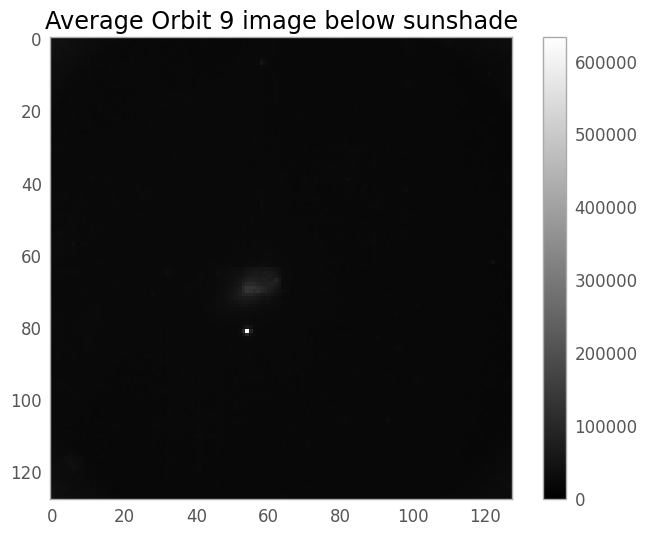

No images below sunshade in orbit 10
No images below sunshade in orbit 11
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O12_background_ccd.pkl'>
71 images averaged in orbit 12


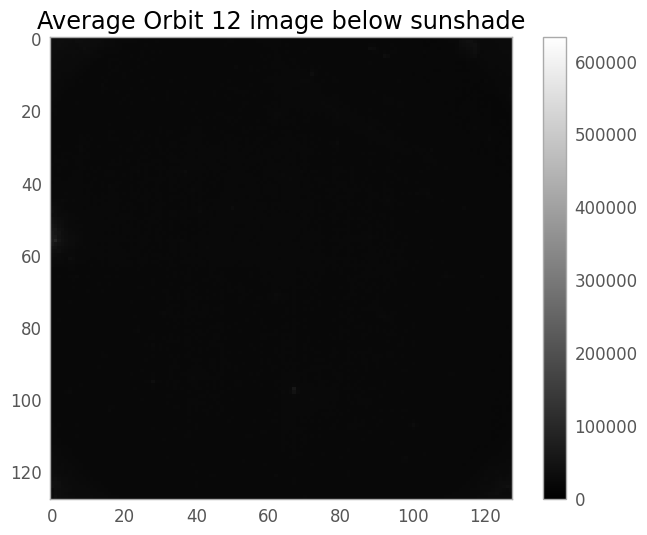

No images below sunshade in orbit 13
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O14_background_ccd.pkl'>
479 images averaged in orbit 14


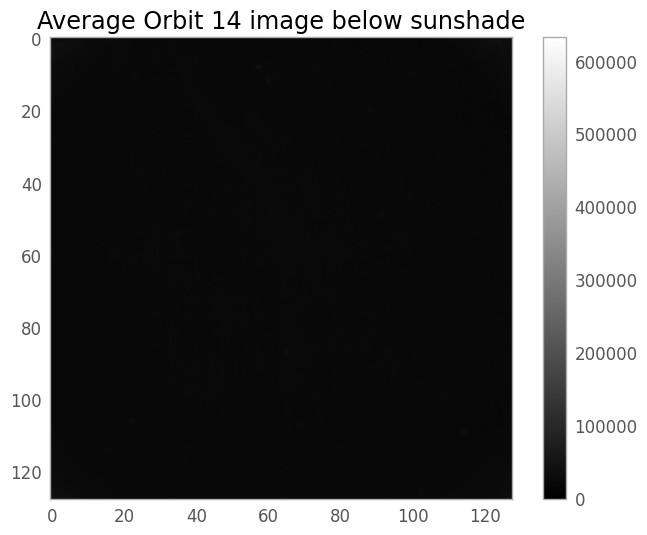

No images below sunshade in orbit 15
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O16_background_ccd.pkl'>
534 images averaged in orbit 16


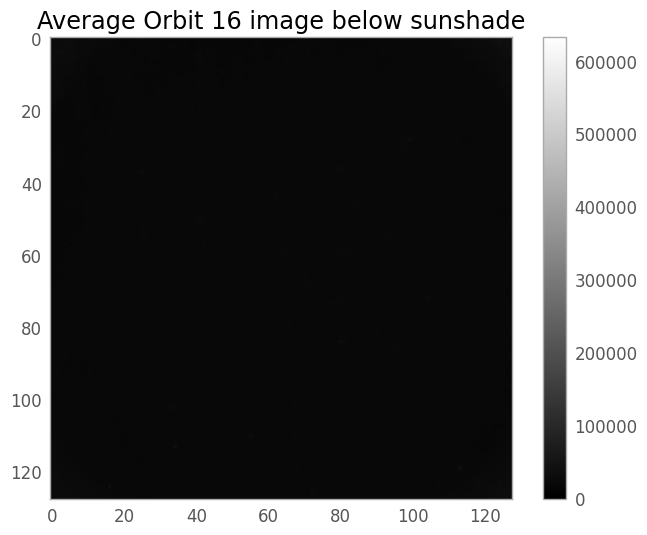

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O17_background_ccd.pkl'>
330 images averaged in orbit 17


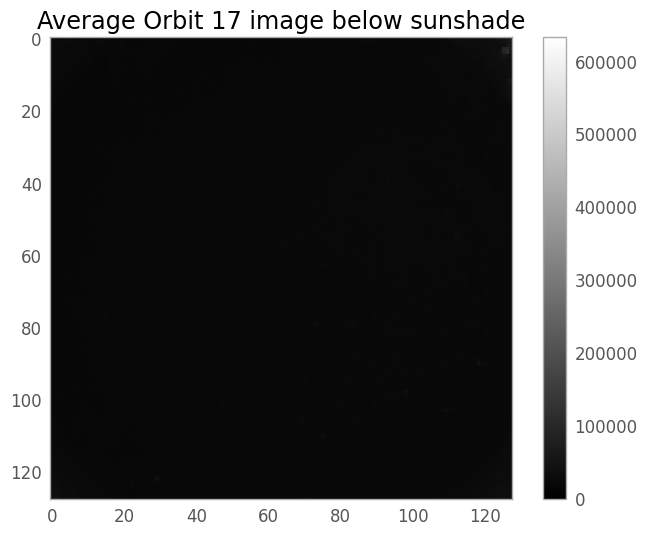

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O18_background_ccd.pkl'>
539 images averaged in orbit 18


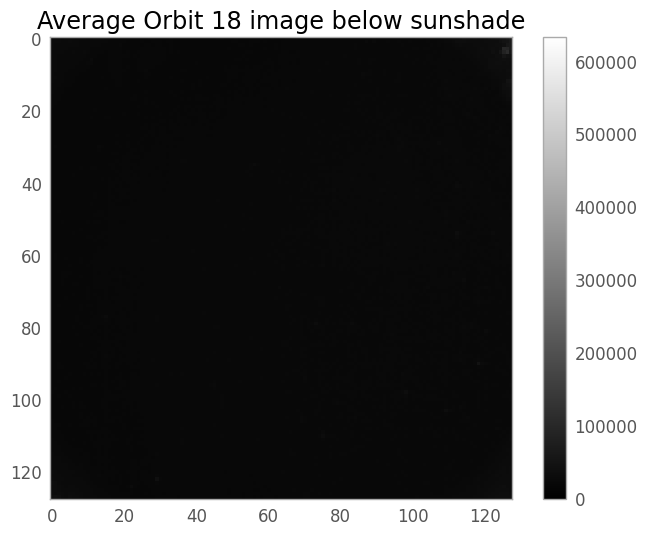

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O19_background_ccd.pkl'>
291 images averaged in orbit 19


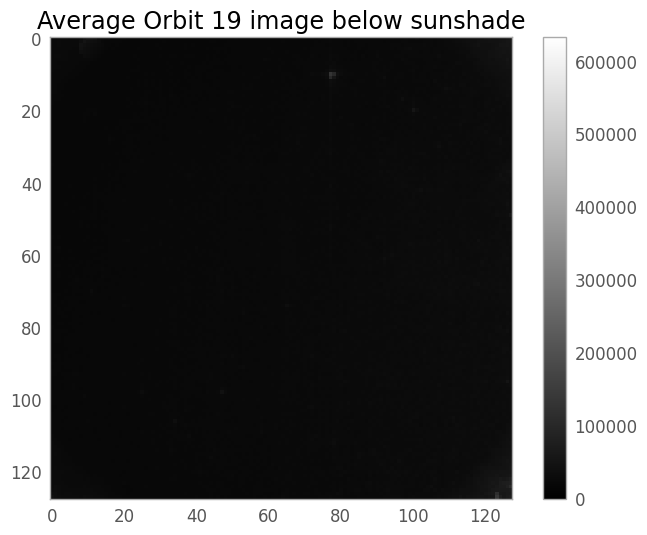

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O20_background_ccd.pkl'>
495 images averaged in orbit 20


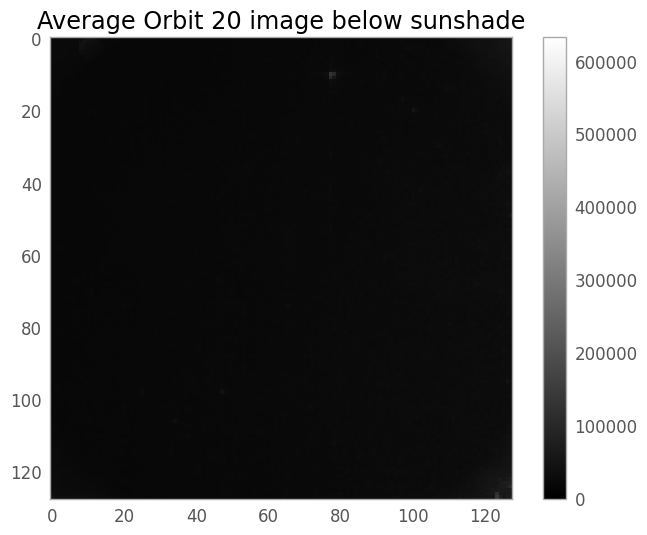

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O21_background_ccd.pkl'>
460 images averaged in orbit 21


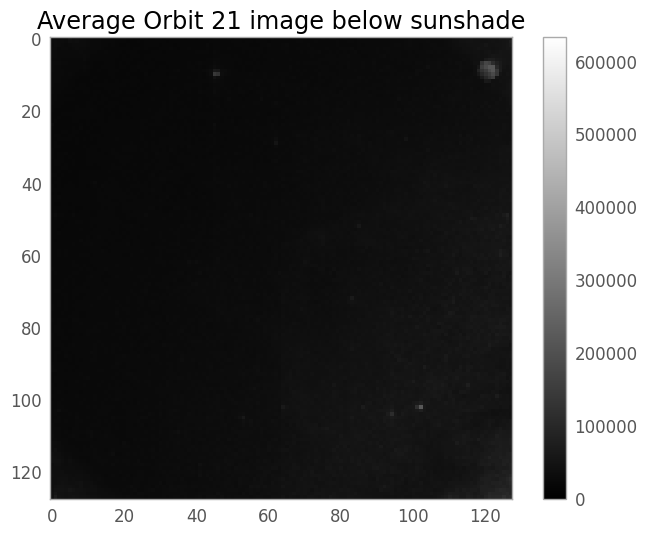

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O22_background_ccd.pkl'>
423 images averaged in orbit 22


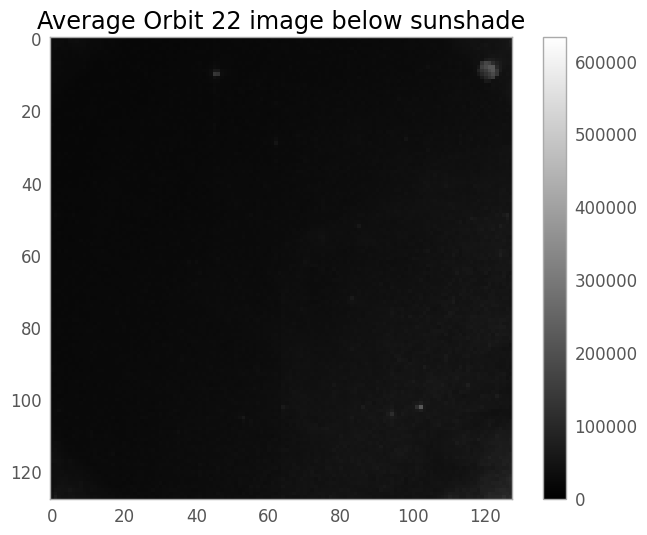

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O23_background_ccd.pkl'>
477 images averaged in orbit 23


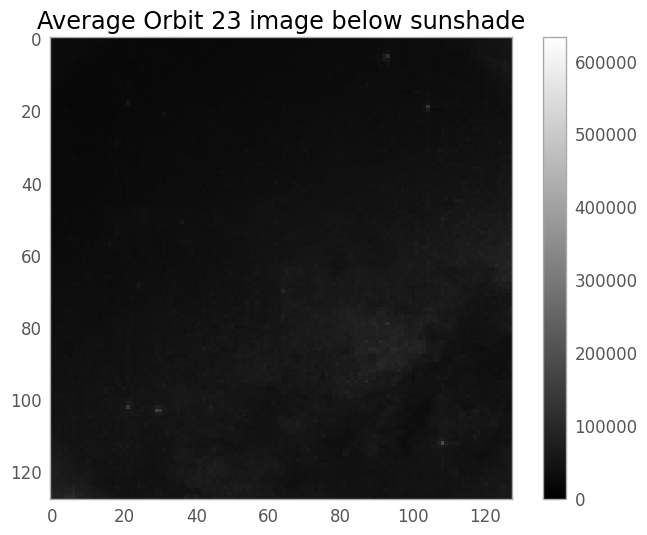

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O24_background_ccd.pkl'>
336 images averaged in orbit 24


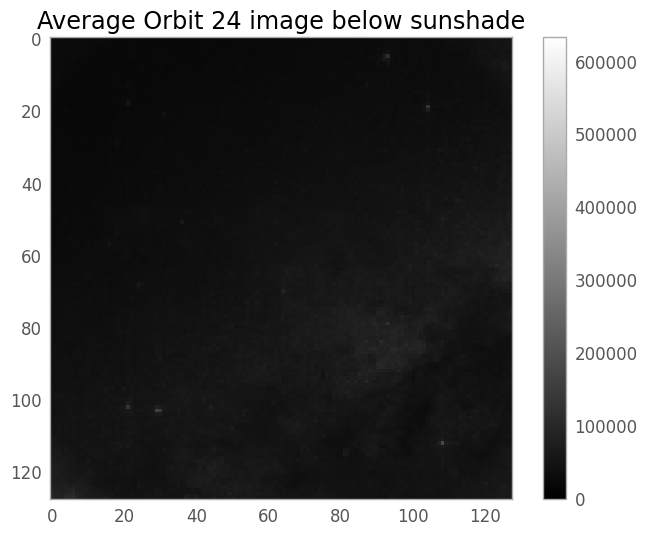

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O25_background_ccd.pkl'>
453 images averaged in orbit 25


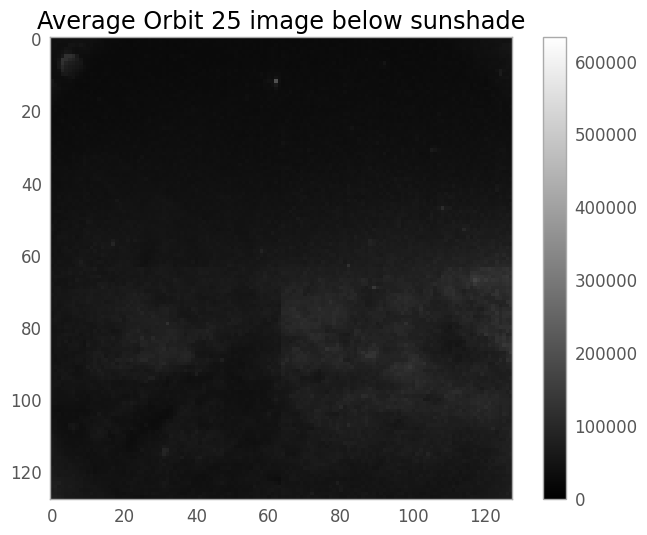

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O26_background_ccd.pkl'>
244 images averaged in orbit 26


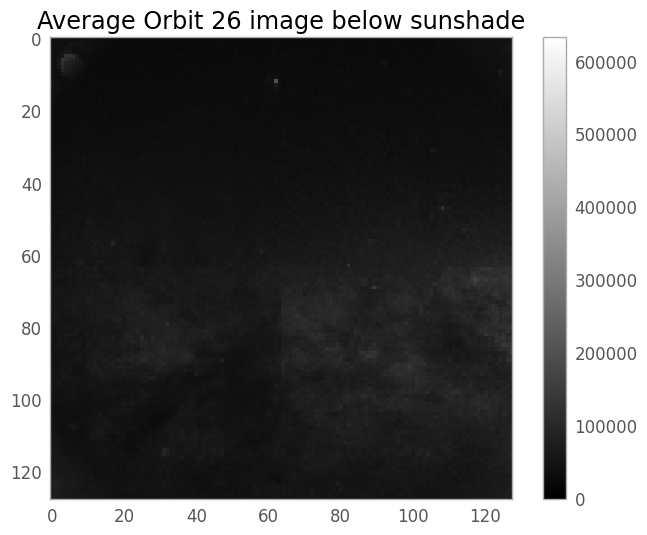

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O27_background_ccd.pkl'>
350 images averaged in orbit 27


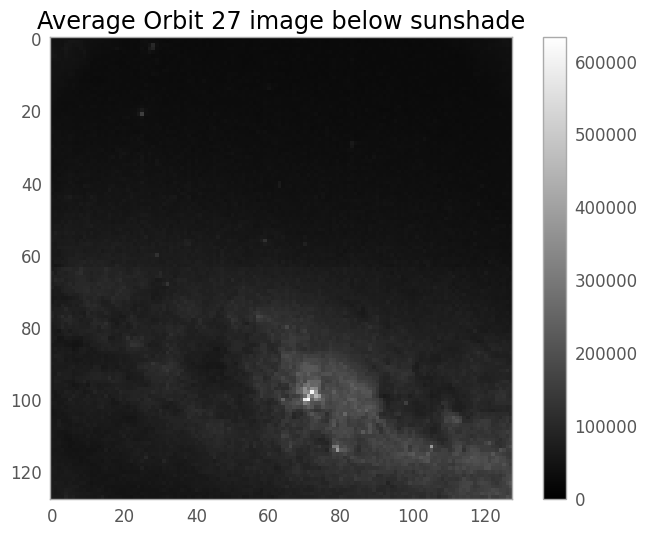

No images below sunshade in orbit 28
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O29_background_ccd.pkl'>
253 images averaged in orbit 29


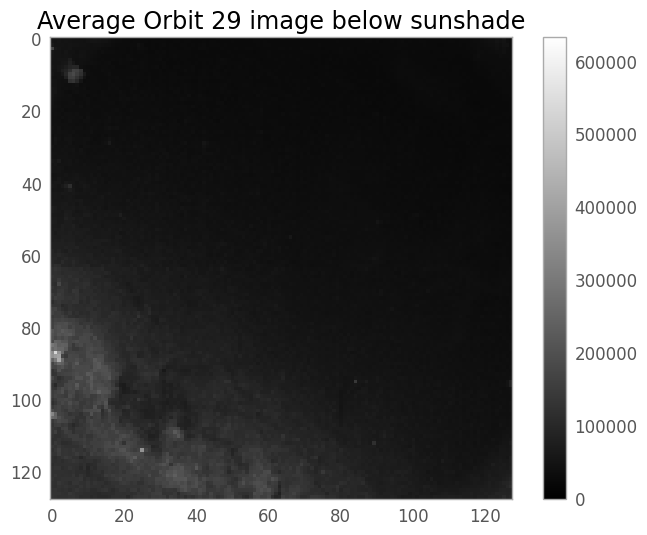

No images below sunshade in orbit 30
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O31_background_ccd.pkl'>
174 images averaged in orbit 31


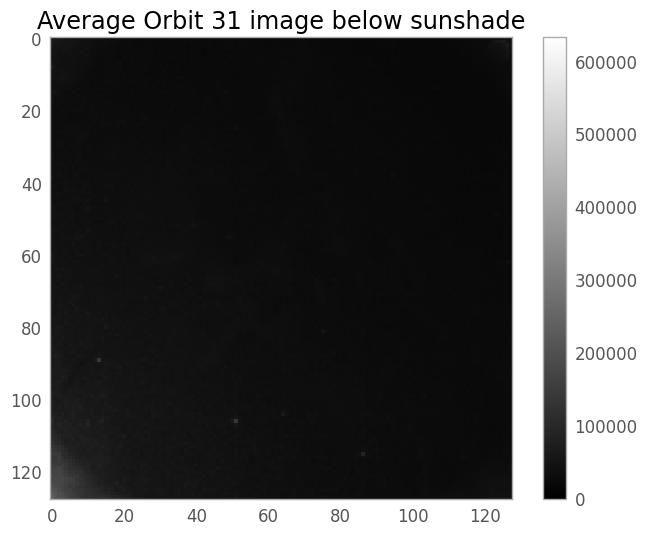

No images below sunshade in orbit 32
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O33_background_ccd.pkl'>
69 images averaged in orbit 33


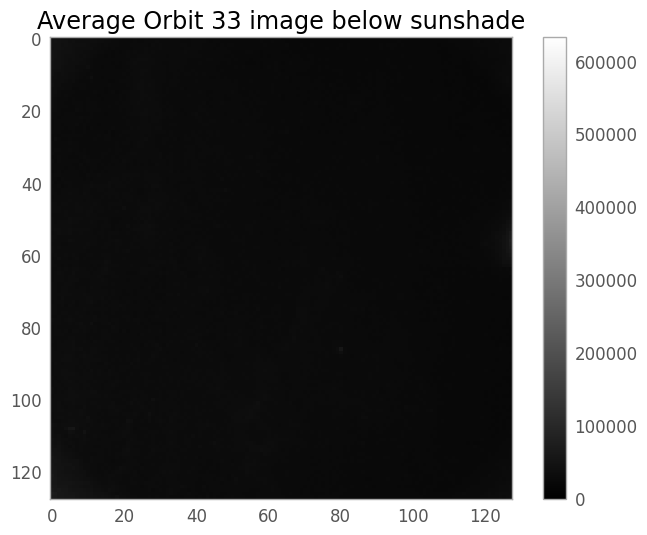

No images below sunshade in orbit 34
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O35_background_ccd.pkl'>
5 images averaged in orbit 35


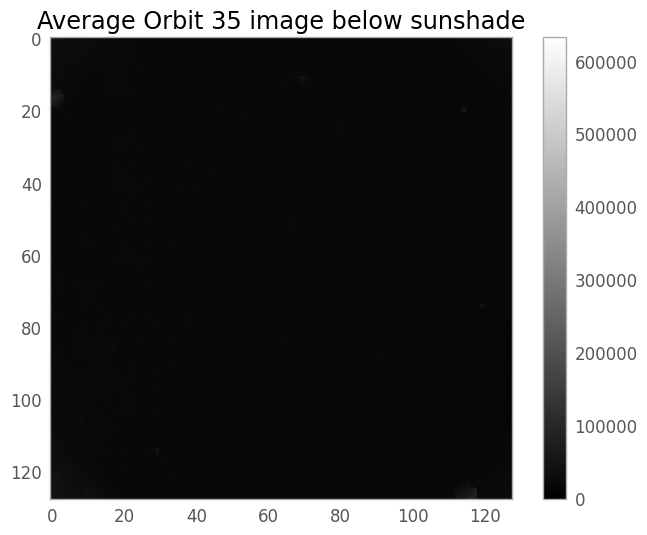

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O36_background_ccd.pkl'>
11 images averaged in orbit 36


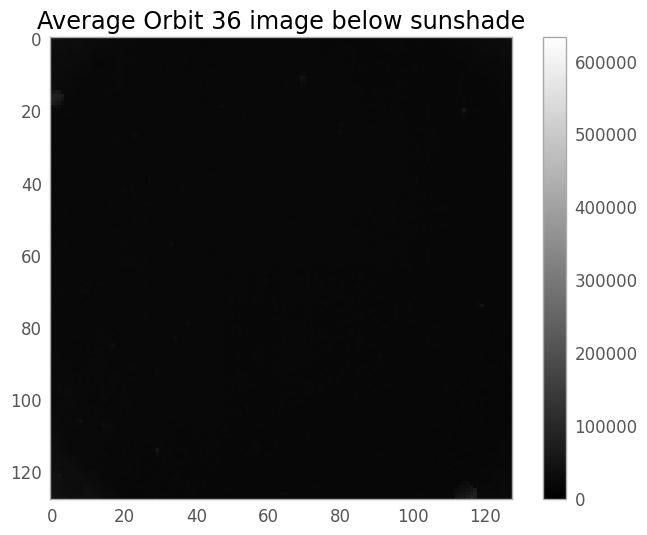

No images below sunshade in orbit 37
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O38_background_ccd.pkl'>
15 images averaged in orbit 38


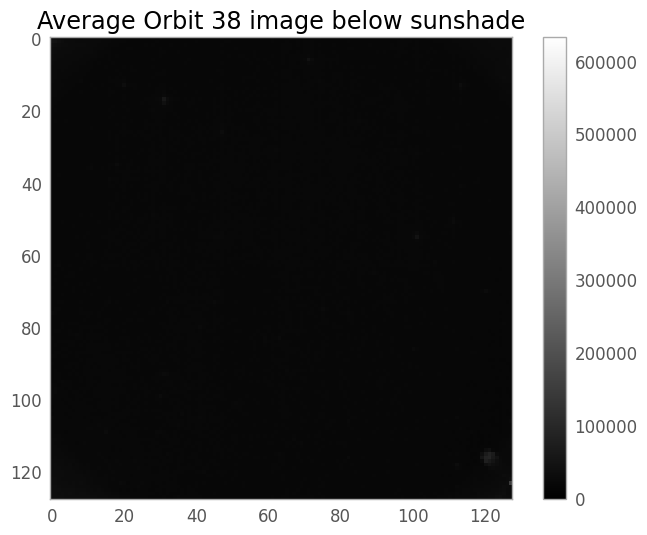

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O39_background_ccd.pkl'>
2 images averaged in orbit 39


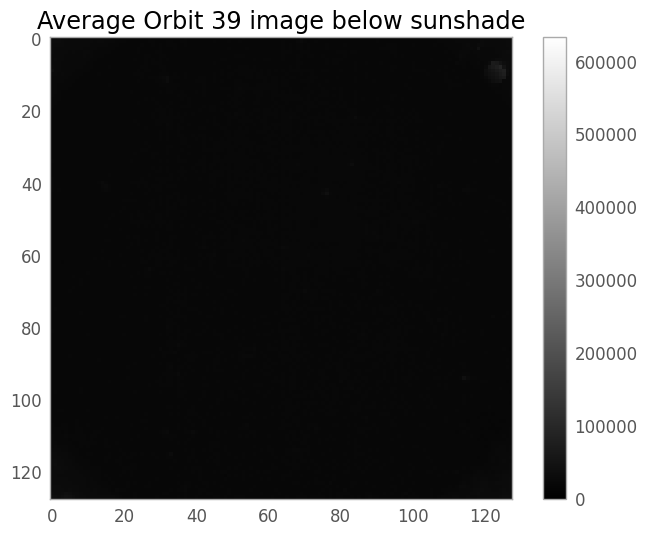

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O40_background_ccd.pkl'>
15 images averaged in orbit 40


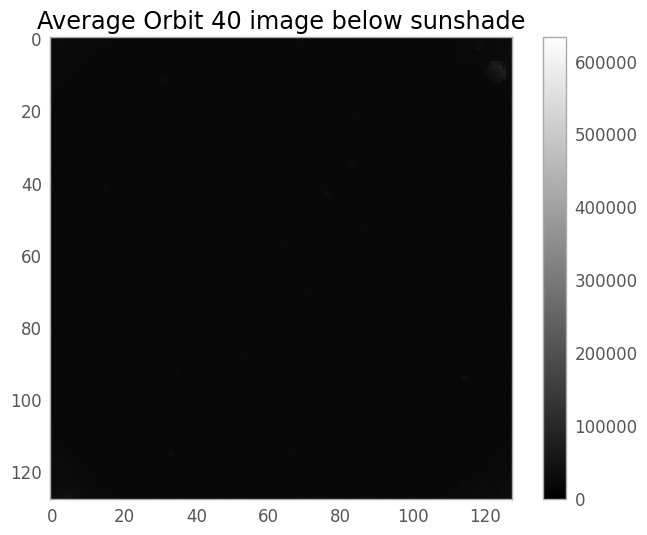

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O41_background_ccd.pkl'>
28 images averaged in orbit 41


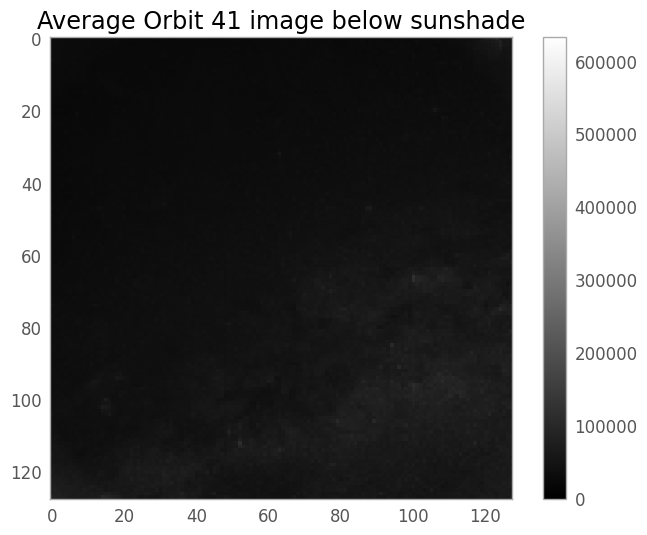

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O42_background_ccd.pkl'>
174 images averaged in orbit 42


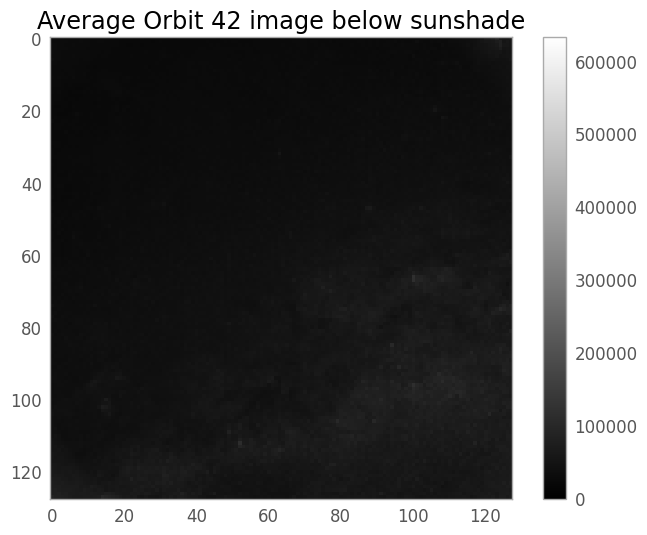

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O43_background_ccd.pkl'>
150 images averaged in orbit 43


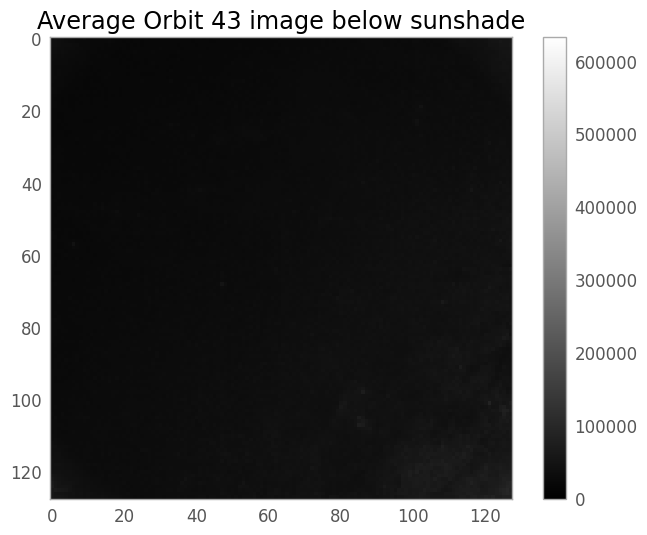

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O44_background_ccd.pkl'>
153 images averaged in orbit 44


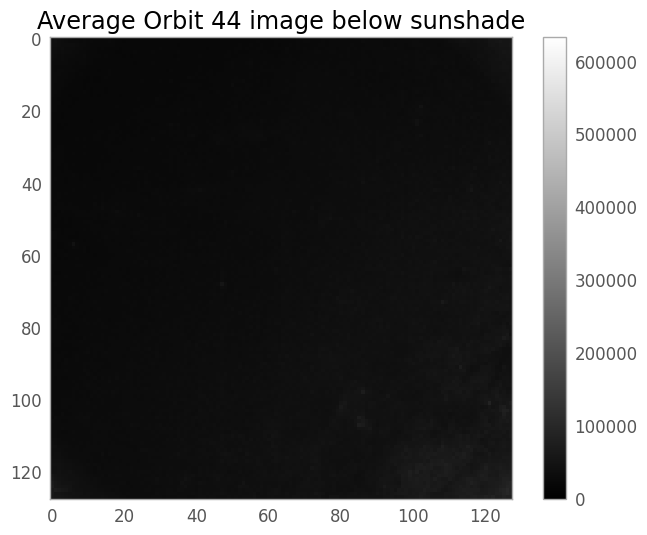

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O45_background_ccd.pkl'>
334 images averaged in orbit 45


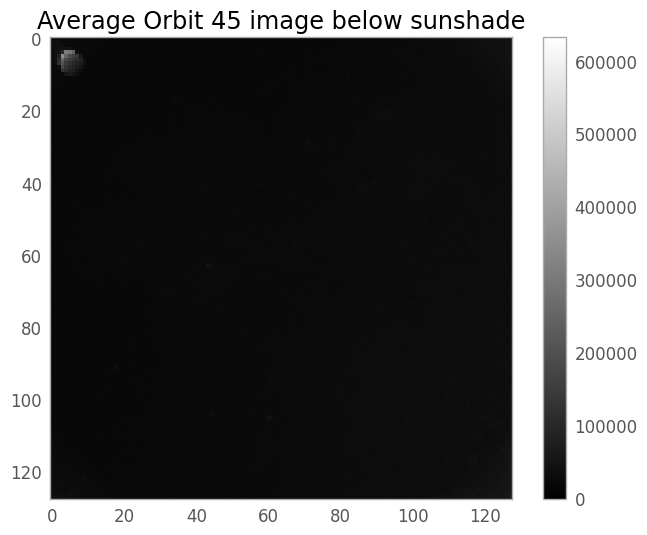

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O46_background_ccd.pkl'>
63 images averaged in orbit 46


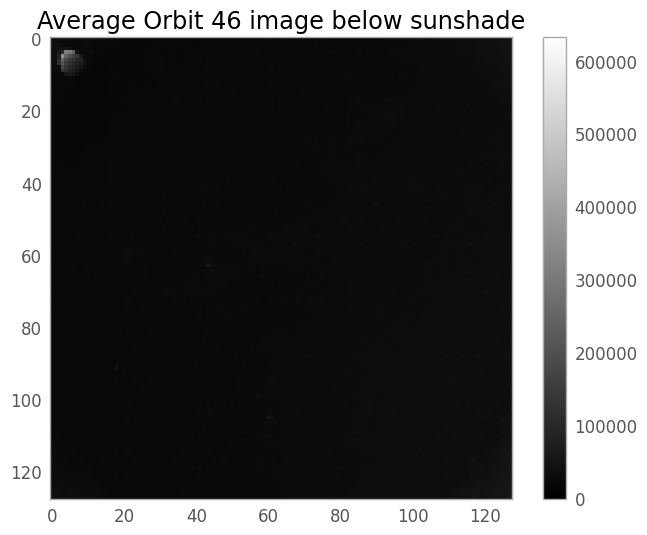

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O47_background_ccd.pkl'>
486 images averaged in orbit 47


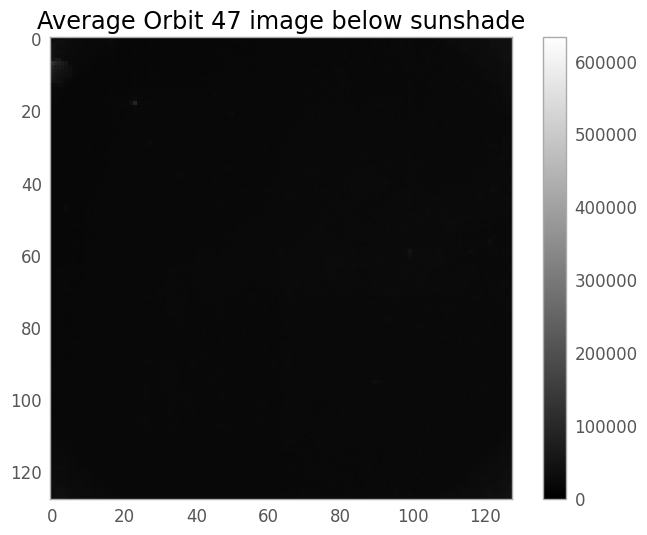

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O48_background_ccd.pkl'>
149 images averaged in orbit 48


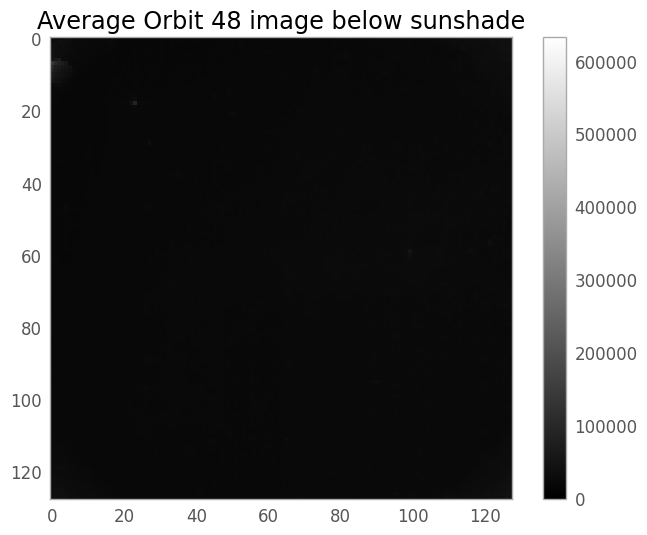

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O49_background_ccd.pkl'>
379 images averaged in orbit 49


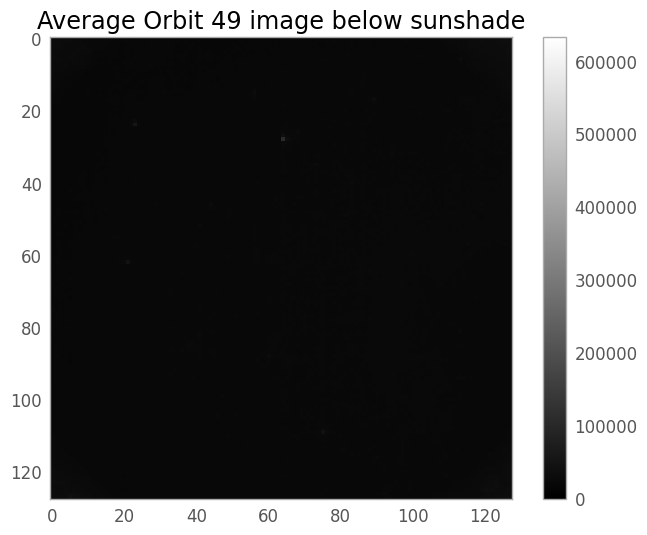

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O50_background_ccd.pkl'>
171 images averaged in orbit 50


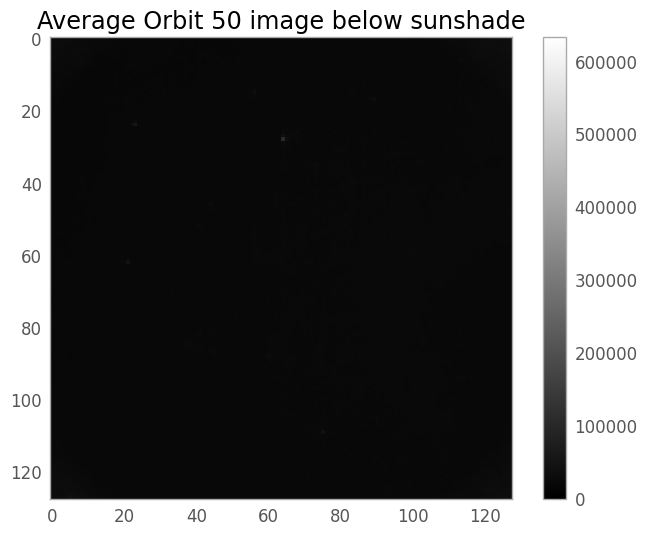

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O51_background_ccd.pkl'>
220 images averaged in orbit 51


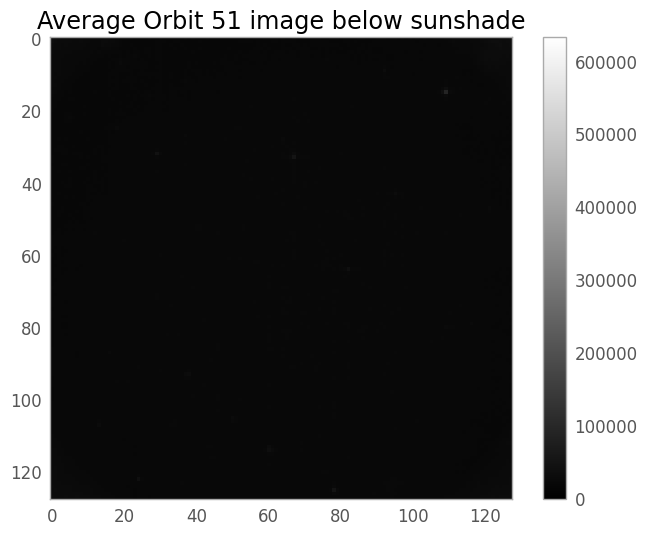

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O52_background_ccd.pkl'>
125 images averaged in orbit 52


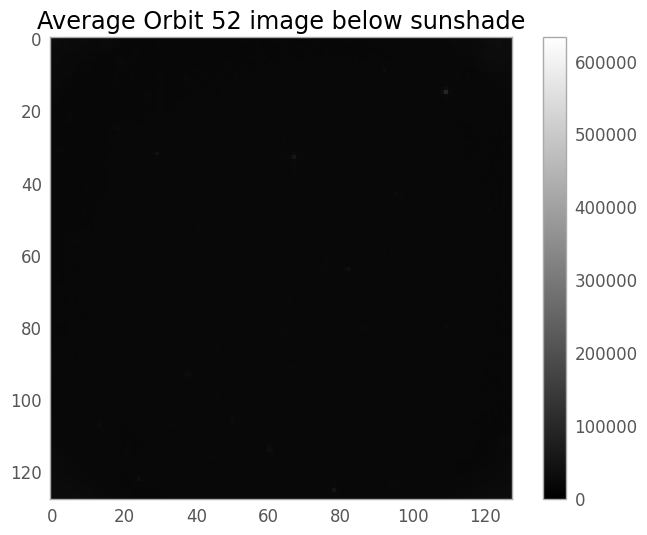

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O53_background_ccd.pkl'>
121 images averaged in orbit 53


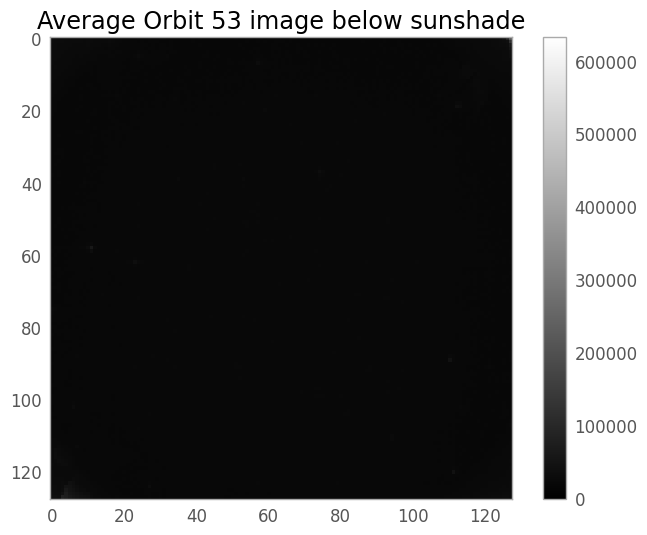

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O54_background_ccd.pkl'>
71 images averaged in orbit 54


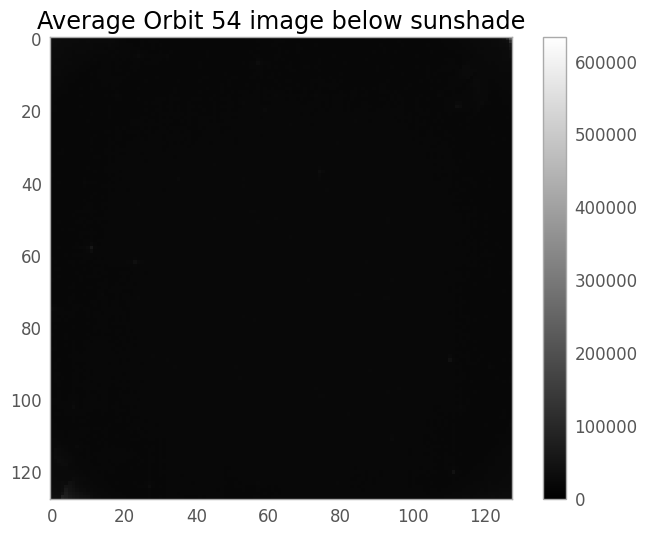

Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O55_background_ccd.pkl'>
17 images averaged in orbit 55


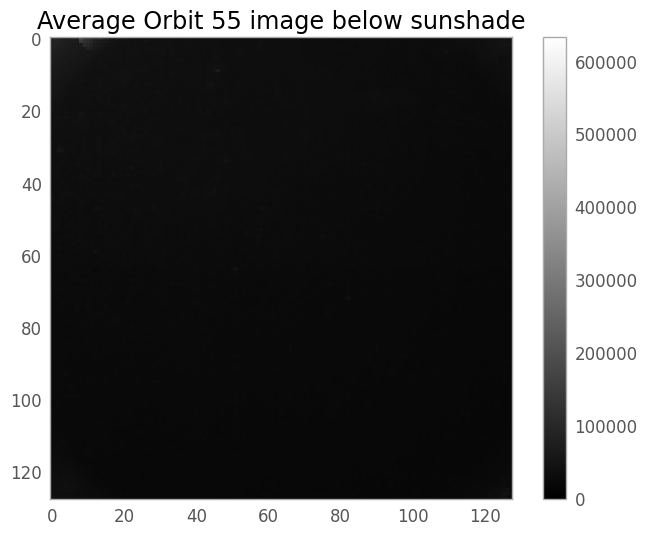

No images below sunshade in orbit 56
No images below sunshade in orbit 57
No images below sunshade in orbit 58
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O59_background_ccd.pkl'>
10 images averaged in orbit 59


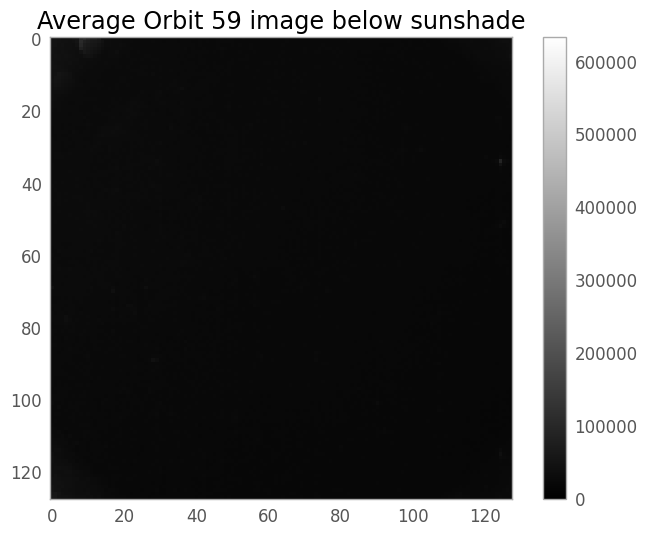

No images below sunshade in orbit 60
No images below sunshade in orbit 61
Saved average background image to <_io.BufferedWriter name='/pdo/users/jlupoiii/TESS/data/background_avg_ccds_im128x128/O62_background_ccd.pkl'>
65 images averaged in orbit 62


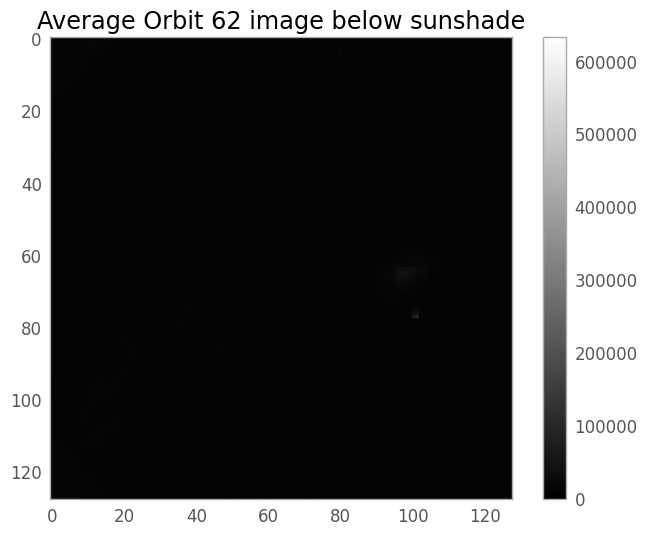

No images below sunshade in orbit 63
Processing images, there are 35884 images in the data dic


orbit 63 images: 100%|█████████████████████| 1744/1744 [00:02<00:00, 738.49it/s]


orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade, skipping subtraction in datasetorbit
 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbitorbit  5757  does not have any images where E + M below sunshade, skipping subtraction in datasetdoes not have any images where E + M below sunshade, skipping subtraction in dataset

orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade, skipping subtraction in dataset
orbit 57 does not have any images where E + M below sunshade

In [8]:
# Run 
processor_save_data = Preprocessing(fits_folder_paths, angle_folder, ccd_folder, background_ccd_folder, raw_angles_file_paths, angle_file, display_images_folder)
processor_save_data.run()